In [1]:
# import library
import re
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# import library untuk text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textattack.augmentation import EasyDataAugmenter
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/home/moseshubert/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moseshubert/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/moseshubert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/moseshubert/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Mendefinisikan fungsi yang diperlukan

In [3]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

In [4]:
# Function to convert  
def listToString(s): 
    # initialize an empty string
    str1 = " " 
    # return string  
    return (str1.join(s))

In [5]:
def cleaner(txt):
    # txt = re.sub("bangkit ", "", txt)
    txt = re.sub("\d+ ", "", txt)
    txt = re.sub("abi farhan ", "", txt)
    txt = re.sub("bangkit ", "", txt)
    return txt

In [6]:
# fungsi mengubah dataset ke dalam bentuk dictionary
def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

In [7]:
# fungsi untuk plot grafik akurasi dan loss
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [8]:
def output(model_output):
    learning_path = ['Android Developer', 'Machine Learning Developer', 'Cloud Developer']
    return learning_path[np.argmax(model_output[0])]

# Mengambil data dan melakukan pre-process

In [9]:
df = pd.read_csv("/home/moseshubert/Documents/bangkit_project/scraping/selenium/linkedin/profil_fix.csv")
df = df.drop(columns=['Name'])
df.head()

,Experience,Label
0,Abi Farhan Android Android Development Android...,0
1,Aceh Community Developer Achinese Android Deve...,0
2,Alodokter for Doctor Android Android Developer...,0
3,Android Developer Student Android Learner Assi...,0
4,Algoritma Data Science School Alterra Academy ...,0


In [10]:
df['Experience'] = df['Experience'].apply(text_process).apply(listToString).apply(cleaner)
df.head()

,Experience,Label
0,android android development android engineer a...,0
1,aceh community developer achinese android deve...,0
2,alodokter doctor android android developer and...,0
3,android developer student android learner assi...,0
4,algoritma data science school alterra academy ...,0


In [11]:
eda_aug = EasyDataAugmenter()

new_experience = []
new_label = []

for ind in df.index:
    new_experience.append(df['Experience'][ind])
    new_label.append(df['Label'][ind])
    exp_augment = eda_aug.augment(df['Experience'][ind])
    new_experience.extend(exp_augment)
    for exp in exp_augment:
        new_label.append(df['Label'][ind])

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/moseshubert/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
df_new = pd.DataFrame(list(zip(new_experience, new_label)), columns =['Experience', 'Label'])
df_new.tail()

,Experience,Label
490,memulai belajar data science bagi pemula bootc...,1
491,memulai instrumentalist belajar player data sc...,1
492,memulai belajar data skill bagi pemula bootcam...,1
493,belajar data science bagi bootcamps participan...,1
494,memulai belajar laboratory science bagi pemula...,1


In [13]:
# membuat dataset menjadi dictionary
data_dict = {
    name:np.array(value)
    for name, value in df_new.items()
}

# menunjukkan data pada course dictionary
for example in slices(data_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

Experience         : android android development android engineer android engineer order management team android engineer external code reviewer dicoding academy led google tokopedia gojek traveloka belajar android jetpack pro bill gate budi luhur university cloud practitioner essential belajar dasar aws cloud english external academy code reviewer android githubusers google awardee indonesia kotlin kotlin developer menjadi android developer expert mobile development graduate distinction mobile development graduated mobile development trainee moviecataloguejetpack samanauser satya nadella shopee universitas budi luhur user experience design ux waresix
Label              : 0


In [14]:
data_exp = data_dict['Experience']
data_exp[:1]

array(['android android development android engineer android engineer order management team android engineer external code reviewer dicoding academy led google tokopedia gojek traveloka belajar android jetpack pro bill gate budi luhur university cloud practitioner essential belajar dasar aws cloud english external academy code reviewer android githubusers google awardee indonesia kotlin kotlin developer menjadi android developer expert mobile development graduate distinction mobile development graduated mobile development trainee moviecataloguejetpack samanauser satya nadella shopee universitas budi luhur user experience design ux waresix'],
      dtype=object)

In [15]:
data_lab = data_dict['Label']
data_lab[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
# mengubah bentuk dictionary menjadi tf dataset
data = tf.data.Dataset.from_tensor_slices((data_exp, data_lab))
data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [17]:
for example, label in data.take(1):
  print('Experience: ', example.numpy())
  print('Label: ', label.numpy())

Experience:  b'android android development android engineer android engineer order management team android engineer external code reviewer dicoding academy led google tokopedia gojek traveloka belajar android jetpack pro bill gate budi luhur university cloud practitioner essential belajar dasar aws cloud english external academy code reviewer android githubusers google awardee indonesia kotlin kotlin developer menjadi android developer expert mobile development graduate distinction mobile development graduated mobile development trainee moviecataloguejetpack samanauser satya nadella shopee universitas budi luhur user experience design ux waresix'
Label:  0


In [18]:
# melakukan shuffle data secara random
tf.random.set_seed(1234)
shuffled = data.shuffle(len(data), seed=1234, reshuffle_each_iteration=False)

In [19]:
batch_size = 32

# memisahkan data menjadi train dan test data
train_dataset = shuffled.take(475).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = shuffled.skip(475).take(20).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
for example, label in train_dataset.take(1):
  print('Experience: ', example.numpy()[1])
  print()
  print('Label: ', label.numpy()[1])

Experience:  b'android development apple developer academy indonesia architecting google compute engine specialization assistant lecturer web development academy graduate distinction bill gate cloud computing academy participant academy denpasar cohort deep encyclopedism specialization ef standard english test english offset range tokopedia fit campus x project from data insight google cloud platform specialization google cloud indonesian javanese jembrana satu data dari desa surveyor Mobile app journal article assessment system junior prentice tech jury favorite award international emerging technology competition kelompok studi technology artisan machine memorize microsoft nix insure robotic technology universitas udayana ryan andriant satya nadella software organize software engineer backend software engineer backend intern software engineer backend traveloka learner apple developer academy toefl teaching assistant algorithm programming tomato harvesting robot traveloka universitas u

In [21]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda Experience, label: Experience))

In [22]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'android', 'developer', 'google', 'cloud', 'learning',
       'academy', 'data', 'student', 'machine', 'engineer', 'development',
       'indonesia', 'belajar', 'universitas', 'university', 'tensorflow',
       'computing', 'programming'], dtype='<U16')

In [23]:
encoded_example = encoder(example)[:1].numpy()
encoded_example

array([[ 33,   7,  42,  33,   7,   5,  54,  33,   7,  42,  33,   7,   5,
        125,   1,  54,   4, 104, 102,  22,   5,  18,  25,   7,  34,   4,
         28,  32,  29, 332, 305, 130,  90, 439, 111,   4,   5,  51,  37,
          5,  11,   4,   5,  51,  96,   5, 842,  51,  58,   1, 433, 441,
        433, 441,   1, 478, 473, 111, 170,  11,   1, 268,  57,   1,  58,
          1, 234, 838,  68,  90, 439, 111, 137,   1, 983, 992, 441, 433,
        172,  57,  28,  15, 359, 323, 277,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0]])

In [24]:
for n in range(1):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'aws academy graduate aws academy cloud architecting aws academy graduate aws academy cloud foundation adaptation architecting google compute engine specialization cloud computing path academy led google tokopedia gojek traveloka ccna cyber security program digitalent scholarship google cloud certified associate cloud engineer google cloud certified professional cloud architect certified network defender huawei datacom huawei datacom msib kampus merdeka scholarship infrastructure engineer manukku capstone project bcap network defense operation blue team program digitalent scholarship networking routing sinom si datacom huawei final project tokopedia universitas gadjah mada ugm'
Round-trip:  aws academy graduate aws academy cloud architecting aws academy graduate aws academy cloud foundation [UNK] architecting google compute engine specialization cloud computing path academy led google tokopedia gojek traveloka ccna cyber security program digitalent scholarship google cloud 

# Membuat model untuk rekomendasi course

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [27]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [28]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [29]:
# Membuat kelas callback agar dapat menentukan indikator training
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Melakukan pengecekan nilai loss dan akurasi saat training
    if(logs.get('loss') < 0.05 and logs.get('accuracy') > 0.95):

      # Mengeluarkan pesan ketika threshold telah ditemui
      print("\nLoss is lower than 0.05 and accuracy is higher than 0.95 so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [30]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=valid_dataset,
                    validation_steps=2,
                    verbose=1,
                    callbacks=[callbacks])

Epoch 1/20


/home/moseshubert/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


15/15 [==============================] - ETA: 0s - loss: 0.9295 - accuracy: 0.6884WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2 batches). You may need to use the repeat() function when building your dataset.


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2 batches). You may need to use the repeat() function when building your dataset.


15/15 [==============================] - 22s 734ms/step - loss: 0.9295 - accuracy: 0.6884 - val_loss: 0.3500 - val_accuracy: 0.9000
Epoch 2/20
15/15 [==============================] - 6s 435ms/step - loss: 0.2224 - accuracy: 0.9432
Epoch 3/20
15/15 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 1.0000
Loss is lower than 0.05 and accuracy is higher than 0.95 so cancelling training!
15/15 [==============================] - 7s 474ms/step - loss: 0.0220 - accuracy: 1.0000


In [31]:
test_loss, test_acc = model.evaluate(valid_dataset)

print('Valid Loss:', test_loss)
print('Valid Accuracy:', test_acc)

1/1 [==============================] - 0s 93ms/step - loss: 0.0037 - accuracy: 1.0000
Valid Loss: 0.0037170113064348698
Valid Accuracy: 1.0


(0.0, 0.9748839490115643)

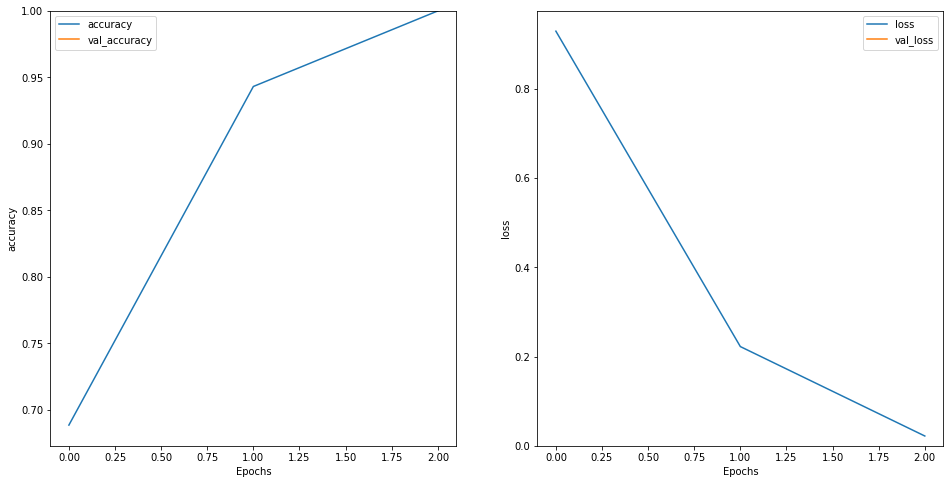

In [32]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Memberikan rekomendasi untuk random people

In [34]:
df_test = pd.read_csv('/home/moseshubert/Documents/bangkit_project/scraping/selenium/linkedin/profil_test.csv')
df_test = df_test.drop(columns=['Label'])
df_test['Experience'] = df_test['Experience'].apply(text_process).apply(listToString)
df_test.head()

,Name,Experience
0,Natassja Arminta P.,best presentation business plan competition bu...
1,Michael Andoko,rd runner up kontes robot indonesia regional i...
2,Mikha Hilliard,arduino ide assistant laboratory engineering p...
3,Annova Gian Paskah,st winner ideax akuo assistant lecturer thermo...
4,Jovan Natalius Marcos,st winner mars international scientific paper ...


In [74]:
predictions = model.predict(np.array([df_test['Experience'].loc[0]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 36ms/step
Rekomendasi learning path: Machine Learning Developer. Tingkat akurasi rekomendasi: 0.9872625470161438.


In [75]:
predictions = model.predict(np.array([df_test['Experience'].loc[1]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 42ms/step
Rekomendasi learning path: Machine Learning Developer. Tingkat akurasi rekomendasi: 0.9952800273895264.


In [76]:
predictions = model.predict(np.array([df_test['Experience'].loc[2]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 43ms/step
Rekomendasi learning path: Machine Learning Developer. Tingkat akurasi rekomendasi: 0.9954965114593506.


In [77]:
predictions = model.predict(np.array([df_test['Experience'].loc[3]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 35ms/step
Rekomendasi learning path: Machine Learning Developer. Tingkat akurasi rekomendasi: 0.9823250770568848.


In [78]:
predictions = model.predict(np.array([df_test['Experience'].loc[4]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 39ms/step
Rekomendasi learning path: Cloud Developer. Tingkat akurasi rekomendasi: 0.9697901010513306.


# Memberikan rekomendasi untuk Bangkit Student

In [79]:
df_test2 = pd.read_csv('/home/moseshubert/Documents/bangkit_project/scraping/selenium/linkedin/profil_test2.csv')
df_test2['Experience'] = df_test2['Experience'].apply(text_process).apply(listToString).apply(cleaner)
df_test2

,Name,Experience
0,Cantika Belia Ananda Nurjasman,android developer belajar android jetpack pro ...
1,Aliffiro Naufal,st winner quran app design it musabaqah nd win...
2,M Daffa Razan,advanced database laboratory assistant android...
3,Dinda Prameswari,architecting google compute engine specializat...
4,Daffa Zidane Laduni,achieving advanced insight bigquery applied da...
5,Muhammad Ilham Hanifan,academy led google tokopedia gojek traveloka c...
6,Raditya Farel,academy led google tokopedia gojek traveloka d...
7,Zarek Gema Galgani,artificial intelligence ai academy machine lea...
8,Nadiya Amanda,algorithm academy led google tokopedia gojek t...


### Android Developer Student

In [80]:
predictions = model.predict(np.array([df_test2['Experience'].loc[0]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 36ms/step
Rekomendasi learning path: Android Developer. Tingkat akurasi rekomendasi: 0.9992469549179077.


In [81]:
predictions = model.predict(np.array([df_test2['Experience'].loc[1]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 38ms/step
Rekomendasi learning path: Android Developer. Tingkat akurasi rekomendasi: 0.9976680874824524.


In [82]:
predictions = model.predict(np.array([df_test2['Experience'].loc[2]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 37ms/step
Rekomendasi learning path: Android Developer. Tingkat akurasi rekomendasi: 0.9513400197029114.


### Cloud Computing Student

In [83]:
predictions = model.predict(np.array([df_test2['Experience'].loc[3]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 33ms/step
Rekomendasi learning path: Cloud Developer. Tingkat akurasi rekomendasi: 0.9506009817123413.


In [84]:
predictions = model.predict(np.array([df_test2['Experience'].loc[4]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 53ms/step
Rekomendasi learning path: Cloud Developer. Tingkat akurasi rekomendasi: 0.9930688142776489.


In [85]:
predictions = model.predict(np.array([df_test2['Experience'].loc[5]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 36ms/step
Rekomendasi learning path: Cloud Developer. Tingkat akurasi rekomendasi: 0.9864258766174316.


### Machine Learning Student

In [86]:
predictions = model.predict(np.array([df_test2['Experience'].loc[6]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 34ms/step
Rekomendasi learning path: Machine Learning Developer. Tingkat akurasi rekomendasi: 0.9990357160568237.


In [87]:
predictions = model.predict(np.array([df_test2['Experience'].loc[7]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 30ms/step
Rekomendasi learning path: Machine Learning Developer. Tingkat akurasi rekomendasi: 0.9989168643951416.


In [88]:
predictions = model.predict(np.array([df_test2['Experience'].loc[8]]))
print("Rekomendasi learning path: {}. Tingkat akurasi rekomendasi: {}.".format(output(predictions), np.max(predictions)))

1/1 [==============================] - 0s 38ms/step
Rekomendasi learning path: Machine Learning Developer. Tingkat akurasi rekomendasi: 0.9985148310661316.


# Menyimpan model untuk deployment

In [53]:
# menyimpan model
model.save('/home/moseshubert/Documents/bangkit_project/classification_model')

Found untraced functions such as lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses, lstm_cell_4_layer_call_fn while saving (showing 5 of 8). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/moseshubert/Documents/bangkit_project/classification_model/assets


Assets written to: /home/moseshubert/Documents/bangkit_project/classification_model/assets


In [54]:
# melakukan load model
new_model = tf.keras.models.load_model('/home/moseshubert/Documents/bangkit_project/classification_model')

# check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        